# Проект: классификация

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

Сначала вставим для удобства сюда описание признаков:
* Данные о клиентах банка:
    * age (возраст);
    * job (сфера занятости);
    * marital (семейное положение);
    * education (уровень образования);
    * default (имеется ли просроченный кредит);
    * housing (имеется ли кредит на жильё);
    * loan (имеется ли кредит на личные нужды);
    * balance (баланс).
* Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:
    * contact (тип контакта с клиентом);
    * month (месяц, в котором был последний контакт);
    * day (день, в который был последний контакт);
    * duration (продолжительность контакта в секундах).
* Прочие признаки:
    * campaign (количество контактов с этим клиентом в течение текущей кампании);
    * pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
    * previous (количество контактов до текущей кампании)
    * poutcome (результат прошлой маркетинговой кампании).
* deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

### Задание 1

In [65]:
df = pd.read_csv('bank_fin.csv', sep = ';')

Посмотрим сначала на признаки и их типы

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


Посмотрим на на верх таблицы, чтобы сориетироваться, что там за данные

In [67]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


Навскидку видно, что есть много категориальных признаков, и из надо будет перекодировать. Balance по сути числовой, надо перевести в число.Посмотрим describe

In [68]:
df.describe(include='object')

,job,marital,education,default,balance,housing,loan,contact,month,poutcome,deposit
count,11162,11162,11162,11162,11137,11162,11162,11162,11162,11162,11162
unique,12,3,4,2,3802,2,2,3,12,4,2
top,management,married,secondary,no,0 $,no,no,cellular,may,unknown,no
freq,2566,6351,5476,10994,774,5881,9702,8042,2824,8326,5873


In [69]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isnull().sum().sort_values(ascending=False)

balance      25
age           0
day           0
poutcome      0
previous      0
pdays         0
campaign      0
duration      0
month         0
contact       0
job           0
loan          0
housing       0
default       0
education     0
marital       0
deposit       0
dtype: int64

Итого имеем 25 пропусков в признаке balance и все, других пропусков нет

### Задание 2

In [70]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
jod_df = df.groupby('job')['job'].value_counts().sort_values(ascending=False)
jod_df

job            job          
management     management       2566
blue-collar    blue-collar      1944
technician     technician       1823
admin.         admin.           1334
services       services          923
retired        retired           778
self-employed  self-employed     405
student        student           360
unemployed     unemployed        357
entrepreneur   entrepreneur      328
housemaid      housemaid         274
unknown        unknown            70
Name: job, dtype: int64

Видим, что пропуски кроются за словом unknown

### Задание 3

In [71]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].apply(lambda x: str(x).replace(' ',''))
df['balance'] = df['balance'].apply(lambda x: str(x).replace('$',''))
df['balance'] = df['balance'].apply(lambda x: str(x).replace(',','.')).astype('float')

In [72]:
df.balance.mean()

1529.1290293615875

### Задание 4

In [73]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())
df.balance.mean()

1526.9360329690019

### Задание 5

In [74]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
j_mode = df['job'].mode()[0]
e_mode = df['education'].mode()[0]
df['job'] = df['job'].apply(lambda x: j_mode if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: e_mode if x == 'unknown' else x)


In [75]:
#Выполним проверку к этому заданию. Расчитаем средний баланс по самой популярной професии + работе
df[ df['job'] == j_mode][df['education'] == e_mode ]['balance'].mean().round(3)

1598.883

### Задание 6

In [76]:
# удалите все выбросы для признака balance
def outliers_iqr_mod(data, feature, log_scale=False, left=1.5, right=1.5): #функция которая по сути возвращает 2 таблицы: выбросы и без выбросов по признаку 
    if log_scale:  #если указываем, что хотим использовать логарифмическую шкалу, что логарифмируем данные по параметру
        x = np.log(data[feature]) #единицу добавляем, чтобы не наткнуться на нулевые расстояния логарифма которых нет
    else:
        x = data[feature] 
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75), # считаем квантили
    iqr = quartile_3 - quartile_1 # считаем межквартильное расстояние
    lower_bound = quartile_1 - (iqr * left) # считаем нижнюю границу уса. Надо понимать, что 1.5 квантильного расстояние - это стандарт. Но можно проявлять творчетво
    display(lower_bound)
    upper_bound = quartile_3 + (iqr * right) # верхняя грань уса
    display(upper_bound)
    outliers = data[(x<lower_bound) | (x > upper_bound)] #отфильтрованные данные вне усов = выбросы
    cleaned = data[(x>=lower_bound) & (x <= upper_bound)] #данные внутри усов
    return outliers, cleaned

outliers, cleaned = outliers_iqr_mod(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

df = cleaned



-2241.0

4063.0

Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

yes    4681
Name: deposit, dtype: int64


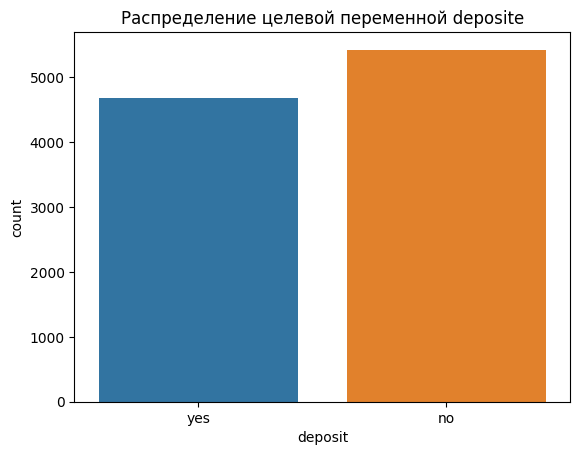

In [77]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
sns.countplot(data=df, x='deposit');
plt.title('Распределение целевой переменной deposite') 
print(df[df['deposit']=='yes']['deposit'].value_counts())

Вывод: Классы сбалансированы. Почти поровну.

### Задания 2 и 3

In [78]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


* **age** - есть клиент 95 лет. Теоретически может быть, но нудно проверить на выбросы по возрасту. Медиана 38 лет выглядит разумно.
* **balance** - Странно если много клиентов с отрицательным балансом. Такое бывает, но их доля, по идее, должны быть невелика. Очень большой разбег между средним и медианой, есть клиенты с балансом сильно выше медианного, возмодны выбросы. Также у четверти клиентов баланс меньше 100$, потенциально это может влиять на решение и быть значимым фактором. Разброс по признаку большой.
* **day** - Явно это число в которое был последний контакт т.к. мин = 1 а макс = 31. Вообще не факт, что признак полезный, по крайней мере, это требует проверки. Можно из этого признака + month вычислить что-то интуитивно более полезное, например, сколько дней прошло с посднего контакта.
* **duration** - вероятно значимый признак. Интуитивно, если контакт был несколько секунд - разговор не состоялся и, возможно, это говорит о лояльности клиента. Интересно посмотреть, как целевая переменная распределена по длительности контакта, возможна зависимость.
* **campaign** - число контактов с клиентом. Вероятны выбросы. И в целом, т.к. медиана 2, а максимум 43, то можно перекодировать в категории типа 1 контакт, 2 контакта, 3, контакт, больше контактов. Возможно целесообразно. Тоде резонно посмотреть на распределение целевого признака по этой переменной.
* **pdays** - странный признак. Вообще не могу понять, что он значит. Полагаю, что -1 означает что-то типа "не было контакта с предыдущей кампании".
* **previous** - с большинством клиентов контактов не было. Но есть странные клиенты, с которыми общаются очень часто. Надо решить выбросы это или же какие-то вип-клиенты с особым вниманием

Построим распределения числовых признаков в разрезе целевого в виде коробок с усами, чтобы прикинуть значимость этих признаков.

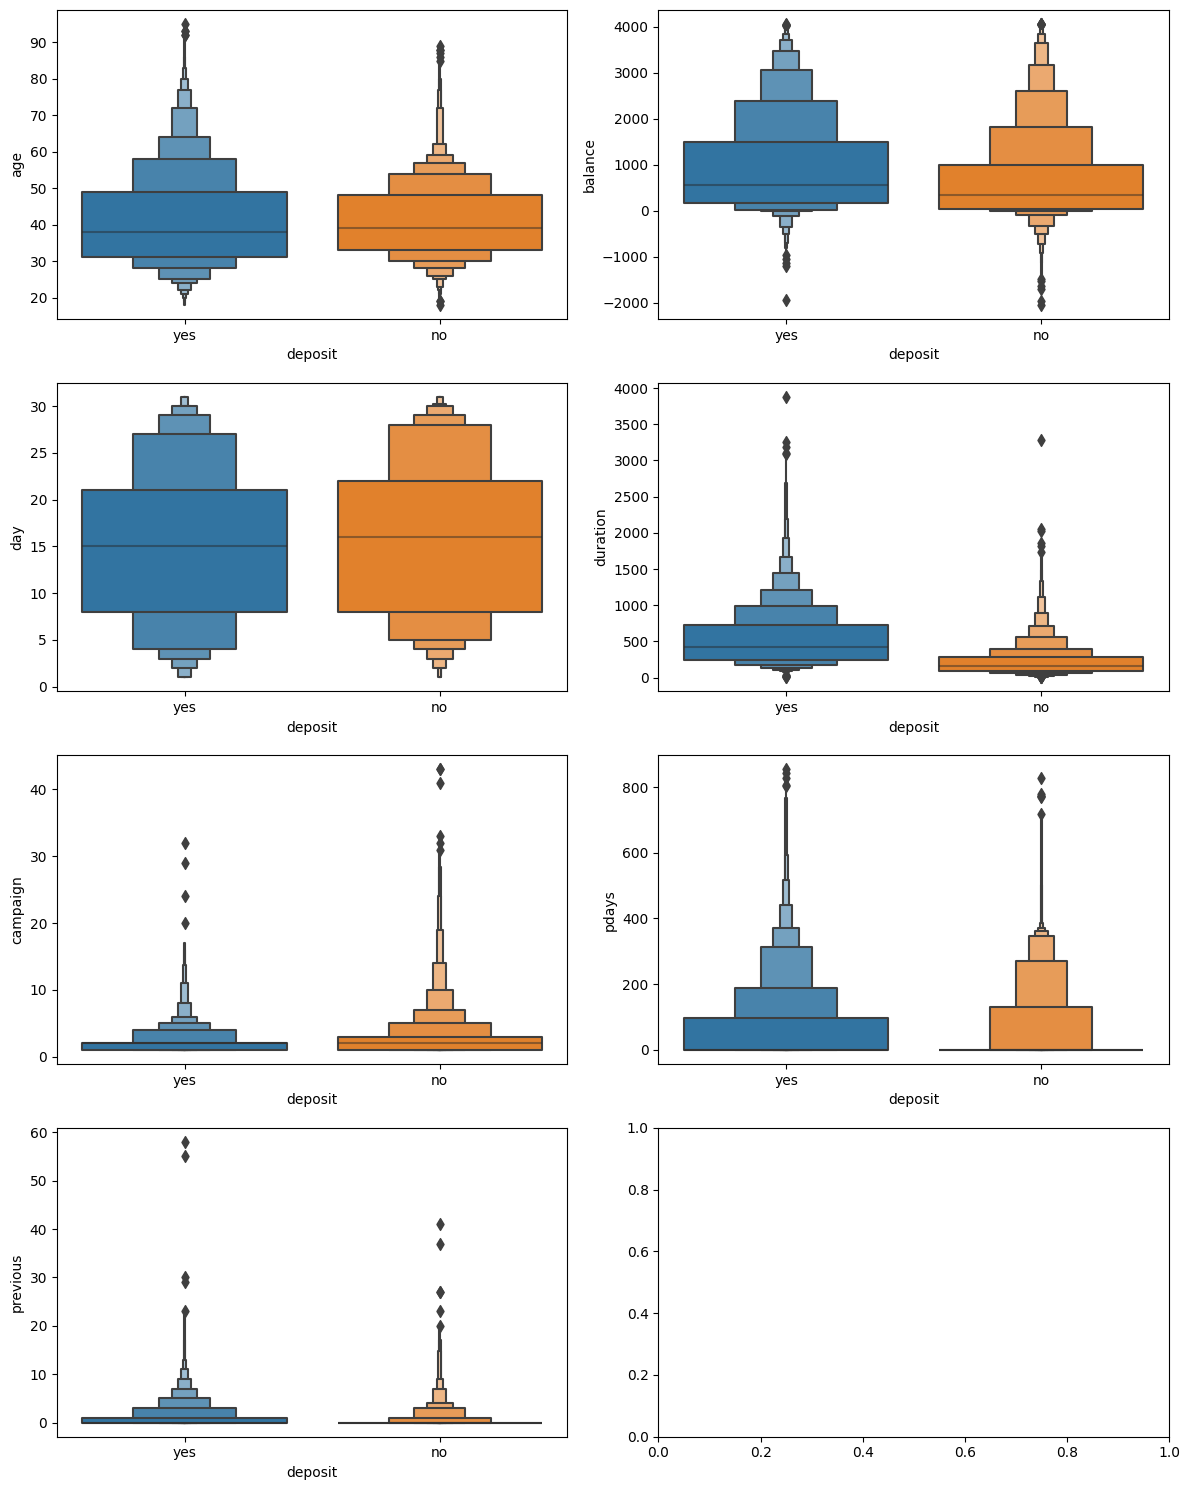

In [79]:
num_features = ['age', 'balance', 'day', 'duration','campaign', 'pdays', 'previous']
n = len(num_features) #число категориальных признаков
#sns.boxenplot(x=df["deposit"], y=df['age'])
#sns.boxenplot(x=df["deposit"], y=df['balance'])
fig, axes = plt.subplots(n//2+1,2,  figsize=(12, 15)) 
#Создаем цикл для всех признаков из списка категориальных признаков
for i,feature in enumerate(num_features):
    sns.boxenplot(x=df["deposit"], y=df[feature], ax=axes[i//2][i%2])
plt.tight_layout() #выравнивание графиков

Предварительные выводы по графикам:
* **age** - я бы сказал, что есть слабая зависимость - более возрастные лучше говорят "да". Но, вероятно, это не самый значимый признак
* **balance** - я бы сказал, что есть слабая зависимость - где больше денег на счету лучше говорят "да". Но, вероятно, это не самый значимый признак
* **day** - я бы сказал, что зависимости почти нет. И гипотеза о том, что лучше изобрести что-то интереснее из него актуальна
* **duration** - Выраженная зависимость. Совпадает с интуицией - те с кем долгий контакт охотнее согласшаются.
* **campaign** - Поразительно, но тут зависимость противоречит моей интуиции. Навскидку она условно "средняя". Но если было много контактов во время текущей компании, то клиент скорее не возьмет депозит. Возможно связано с жалобами. Непонятно.
* **campaign** - Поразительно, но тут зависимость противоречит моей интуиции. Навскидку она условно "средняя". Но если было много контактов во время текущей компании, то клиент скорее не возьмет депозит. Возможно связано с жалобами. Непонятно.
* **pdays** - Средняя или слабая зависимость просматривается. И опять же больше "да" там где больше дней пропущено с кампании до контакта. Удивительно вообще-то
* **previous** - Средняя или слабая зависимость просматривается. Больше "да" там где больше контактов. Но в "нет" больше выбросов.

### Задания 4 и 5

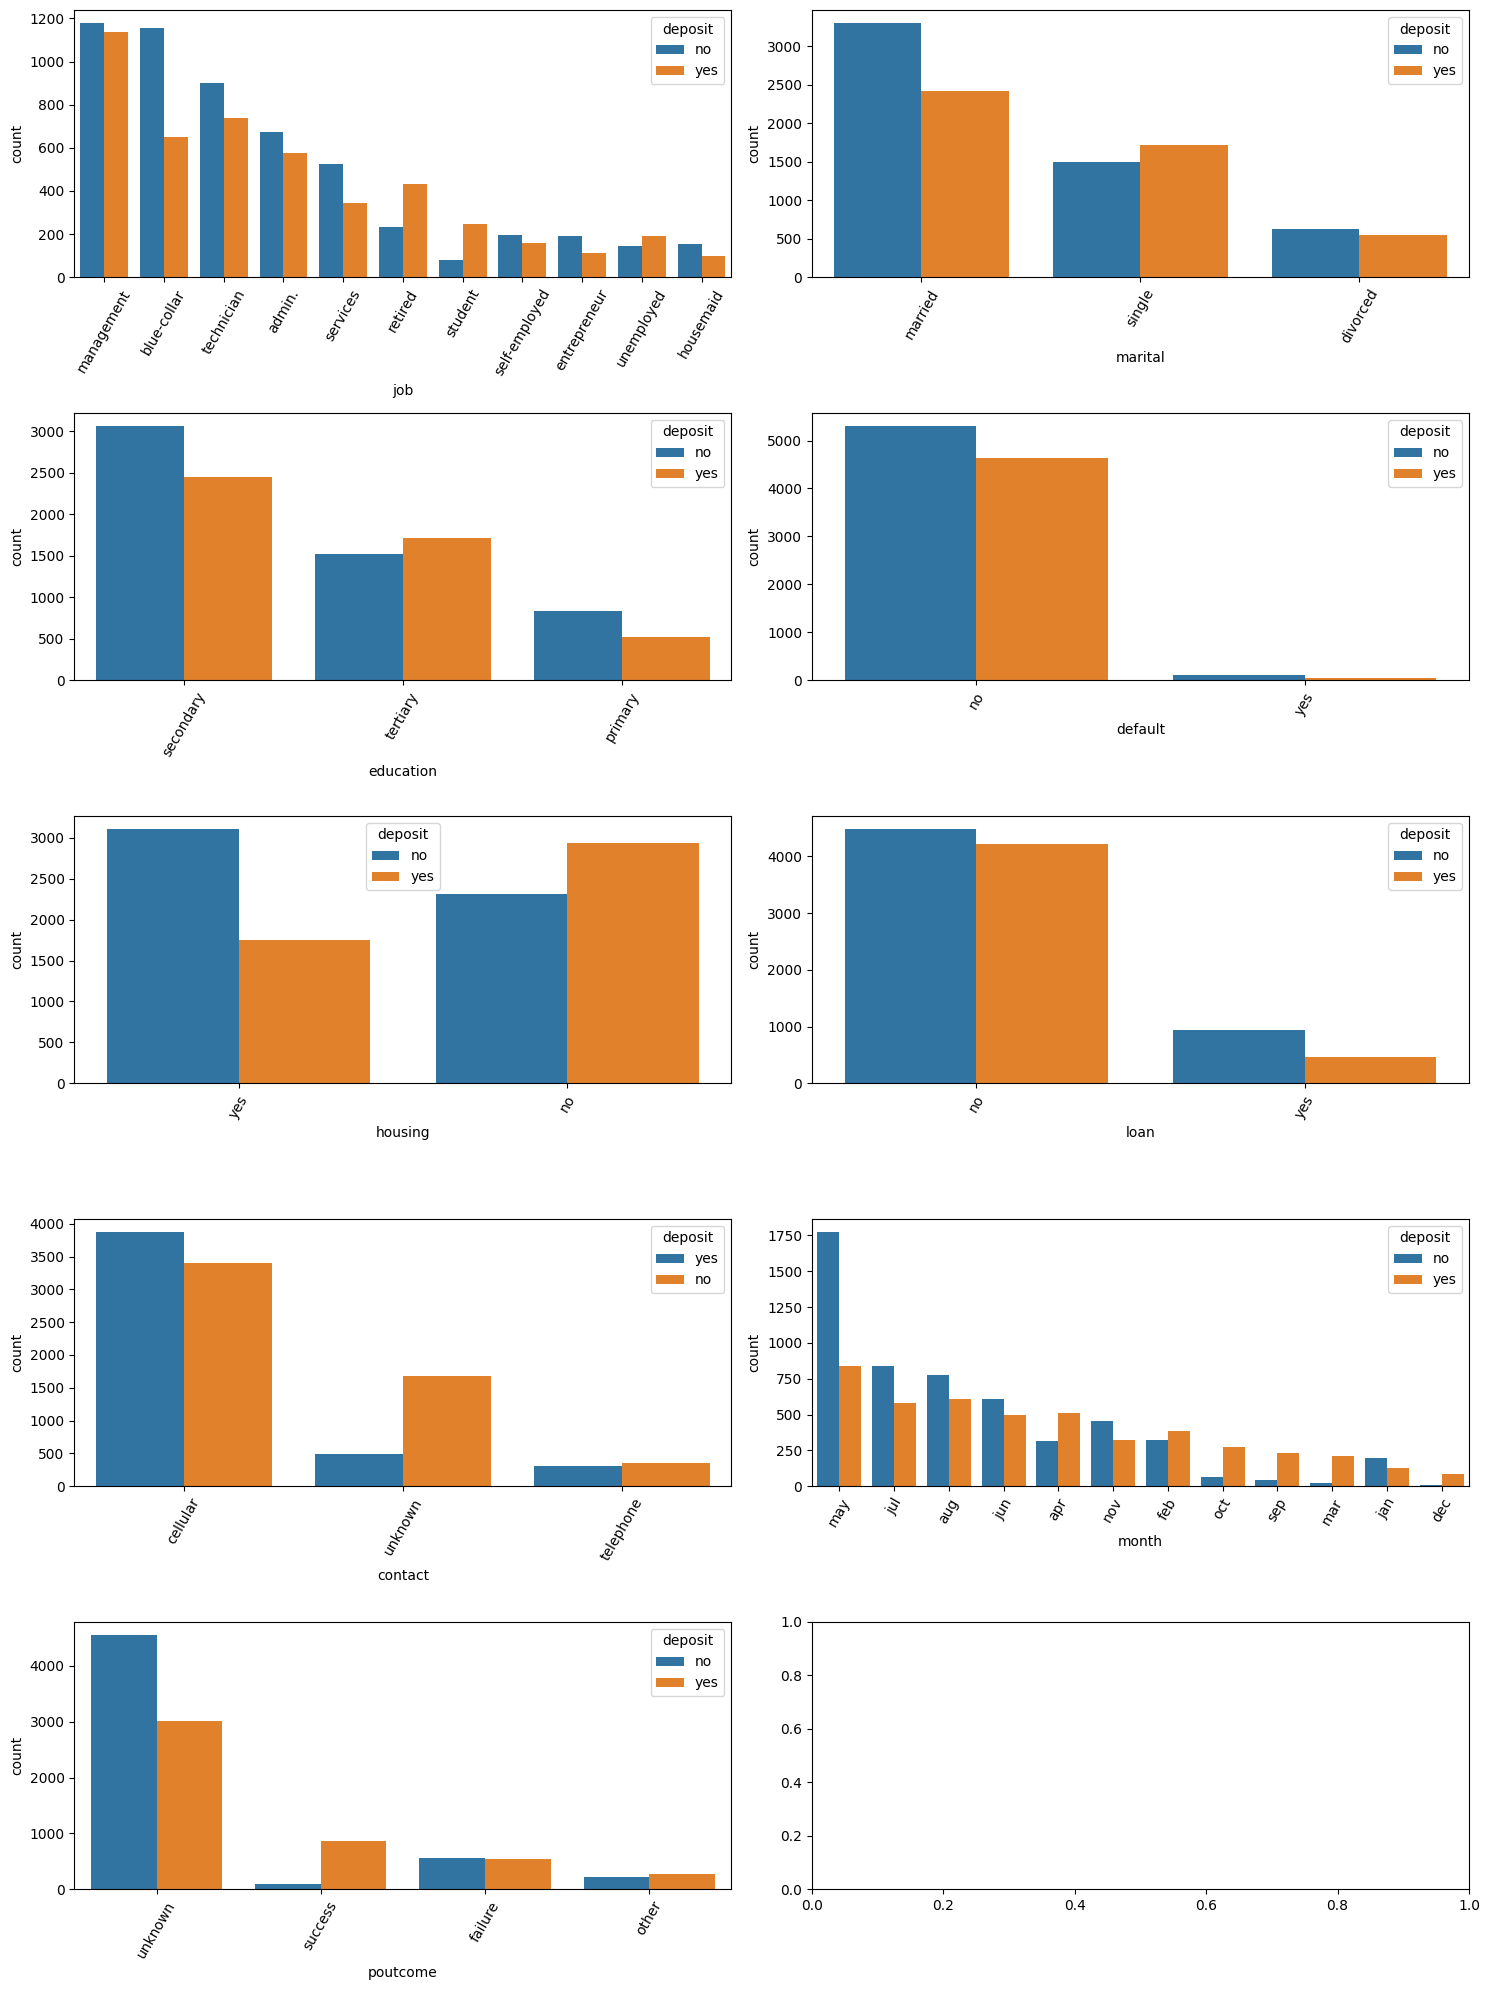

In [80]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
df.describe(include='object')
#постройте визуализации, иллюстрирующие результаты
cat_features = ['job', 'marital', 'education', 'default','housing', 'loan', 'contact', 'month', 'poutcome']
n = len(cat_features) #число категориальных признаков
fig, axes = plt.subplots(n//2+1, 2, figsize=(15, 20)) #фигура+n*2 координатных плоскостей
#Создаем цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    #Строим количественную столбчатую для долевого соотношения каждой из категорий в данных
    count_data = (df.groupby(feature)['deposit'].value_counts()
                  .sort_values(ascending=False)
                  .rename('count')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x=feature, y='count', hue = 'deposit', ax=axes[i//2][i%2])
    count_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков

Вот тут конечно поле для интерпретаций:
1. **job** - тип занятости влияет на решение явно. Например студенты и уволенные открывают депозиты явно охотнее, чем другие. Зависимость есть и существенная.
2. **marital** - семейное положение тоже значимый фактор. С одинокими больше шансов, чем с состоящими в браке
3. **education** - тоже сущесвенный фактор. Выше шансы с людьми с высшим образованием.
4. **default** - а вот существенность этого признака под вопросом. Просто людей с просрочкой в выборке мало очень. 
5. **housing** - наличие ипотеки очень значимо! Те у кого нет, более вероятные претенденты.
6. **loan** - тут тоже есть зависимость, без займов наличными соглашаются вероятнее.
7. **contact** - есть зависимость. И удивительно, что тут unknown - явно не пропуск. И существенно влияет на решение. Как впрочем и тип контакта по телефону или по мобильнику.
8. **month** - результат противоречит моей интуиции, но зависимость от месяца явная. Возможно связано с датами проведения кампаний, а возможно с какой-то сезонностью
9. **poutcome** - тоже unknown нельзя воспринимать, как пропуск. И значимость есть. Те кто согласился раз - соглашаются и второй раз.

### Задание 6

In [81]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# вообще из графика выше видно. Читай выводы предыдущего пункта по признаку poutcome

### Задание 7

In [82]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# вообще из графика выше видно, что май

### Задание 8

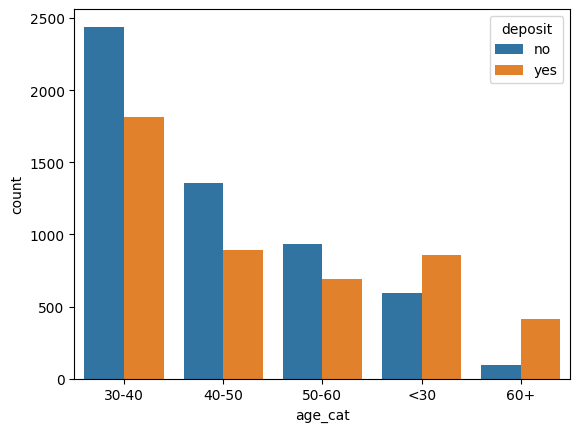

In [83]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
#'<30';
#'30-40';
#'40-50';
#'50-60';
#'60+'.
def set_age_cat(x):
    if x<30:
        return '<30'
    elif x<=40:
        return '30-40'
    elif x<=50:
        return '40-50'
    elif x<=60:
        return '50-60'
    else:
        return '60+'

df['age_cat'] = df['age'].apply(set_age_cat)

count_data = (df.groupby('age_cat')['deposit'].value_counts()
                  .sort_values(ascending=False)
                  .rename('count')
                  .reset_index())
count_barplot = sns.barplot(data=count_data, x='age_cat', y='count', hue = 'deposit')


Вывод: самые молодые и самые взрослые склонны соглашаться больше

### Задания 9 и 10

In [84]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
# уже сделано выше

In [85]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
# уже сделано выше

In [86]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
# уже сделано выше

### Задание 11

<AxesSubplot: xlabel='marital', ylabel='education'>

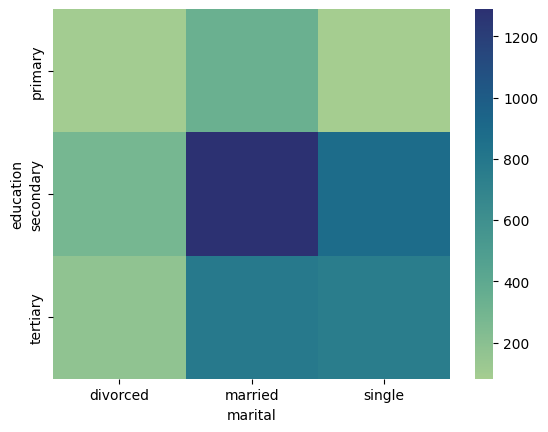

In [87]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
pivot_yes = pd.pivot_table(data = df[df['deposit']=='yes'], index = 'education', columns='marital', values ='job', aggfunc='count').rename(columns={'job':'count'})

sns.heatmap(pivot_yes, cmap="crest")

<AxesSubplot: xlabel='marital', ylabel='education'>

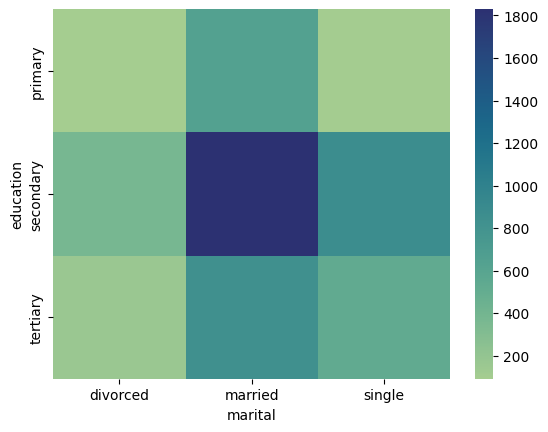

In [88]:
pivot_no = pd.pivot_table(data = df[df['deposit']=='no'], index = 'education', columns='marital', values ='job', aggfunc='count').rename(columns={'job':'count'})
sns.heatmap(pivot_no, cmap="crest")

Самая популярная группа в сочетании "семеное положение / образование" - в браке cо средним образованием в обеих слчаях вне зависимости от решения по депощиту

## Часть 3: преобразование данных

### Задание 1

In [89]:
# преобразуйте уровни образования
LE=LabelEncoder()
df['education'] = LE.fit_transform(df['education'])
df['education'].sum()

11995

In [90]:
#преобразуем наши категории возраста таким же способом (просто пронумеровав)
df['age_cat'] = LE.fit_transform(df['age_cat'])

### Задания 2 и 3

In [91]:
# преобразуйте бинарные переменные в представление из нулей и единиц
# Сделаем это вручную. Все 3 бинарных признака и целевая переменная принимают значения yes/no. Закодируем из чтобы это = 1/0 
binary_features = ['loan','housing', 'default', 'deposit']
for feature in binary_features:
    df[feature] = df[feature].apply(lambda x: 0 if x == 'no' else 1)


In [92]:
df['deposit'].std()

0.4986712532452124

In [93]:
df['loan'].mean() +df['housing'].mean() + df['default'].mean()

0.6354280059376547

### Задание 4

In [94]:
# создайте дамми-переменные
#'job';
#'marital';
#'contact';
#'month';
#'poutcome'.
df = pd.get_dummies(df, columns=['job','marital','contact','month','poutcome'])

In [95]:
len(list(df.columns))+5-1 
#по заданию надо без целевой переменной и с учетом исходный некодированных OneHotEncoding признаков, 
# но getdummies уничтожает станые признаки, поэтому добавим 5 для задания и отнимем 1 целевой

50

### Задания 5 и 6

In [96]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
#Теперь давайте оценим мультиколлинеарность и взаимосвязь признаков с целевой переменной.
#Для этого постройте матрицу корреляций. Дополните её тепловой картой, отражающей результат. Не забудьте, что для того, 
# чтобы вычислить коэффициенты корреляции, необходимо, чтобы целевая переменная была числовой.
#В качестве дополнения визуализации к этому заданию постройте столбчатую диаграмму для ранжированных коэффициентов корреляции.

<AxesSubplot: >

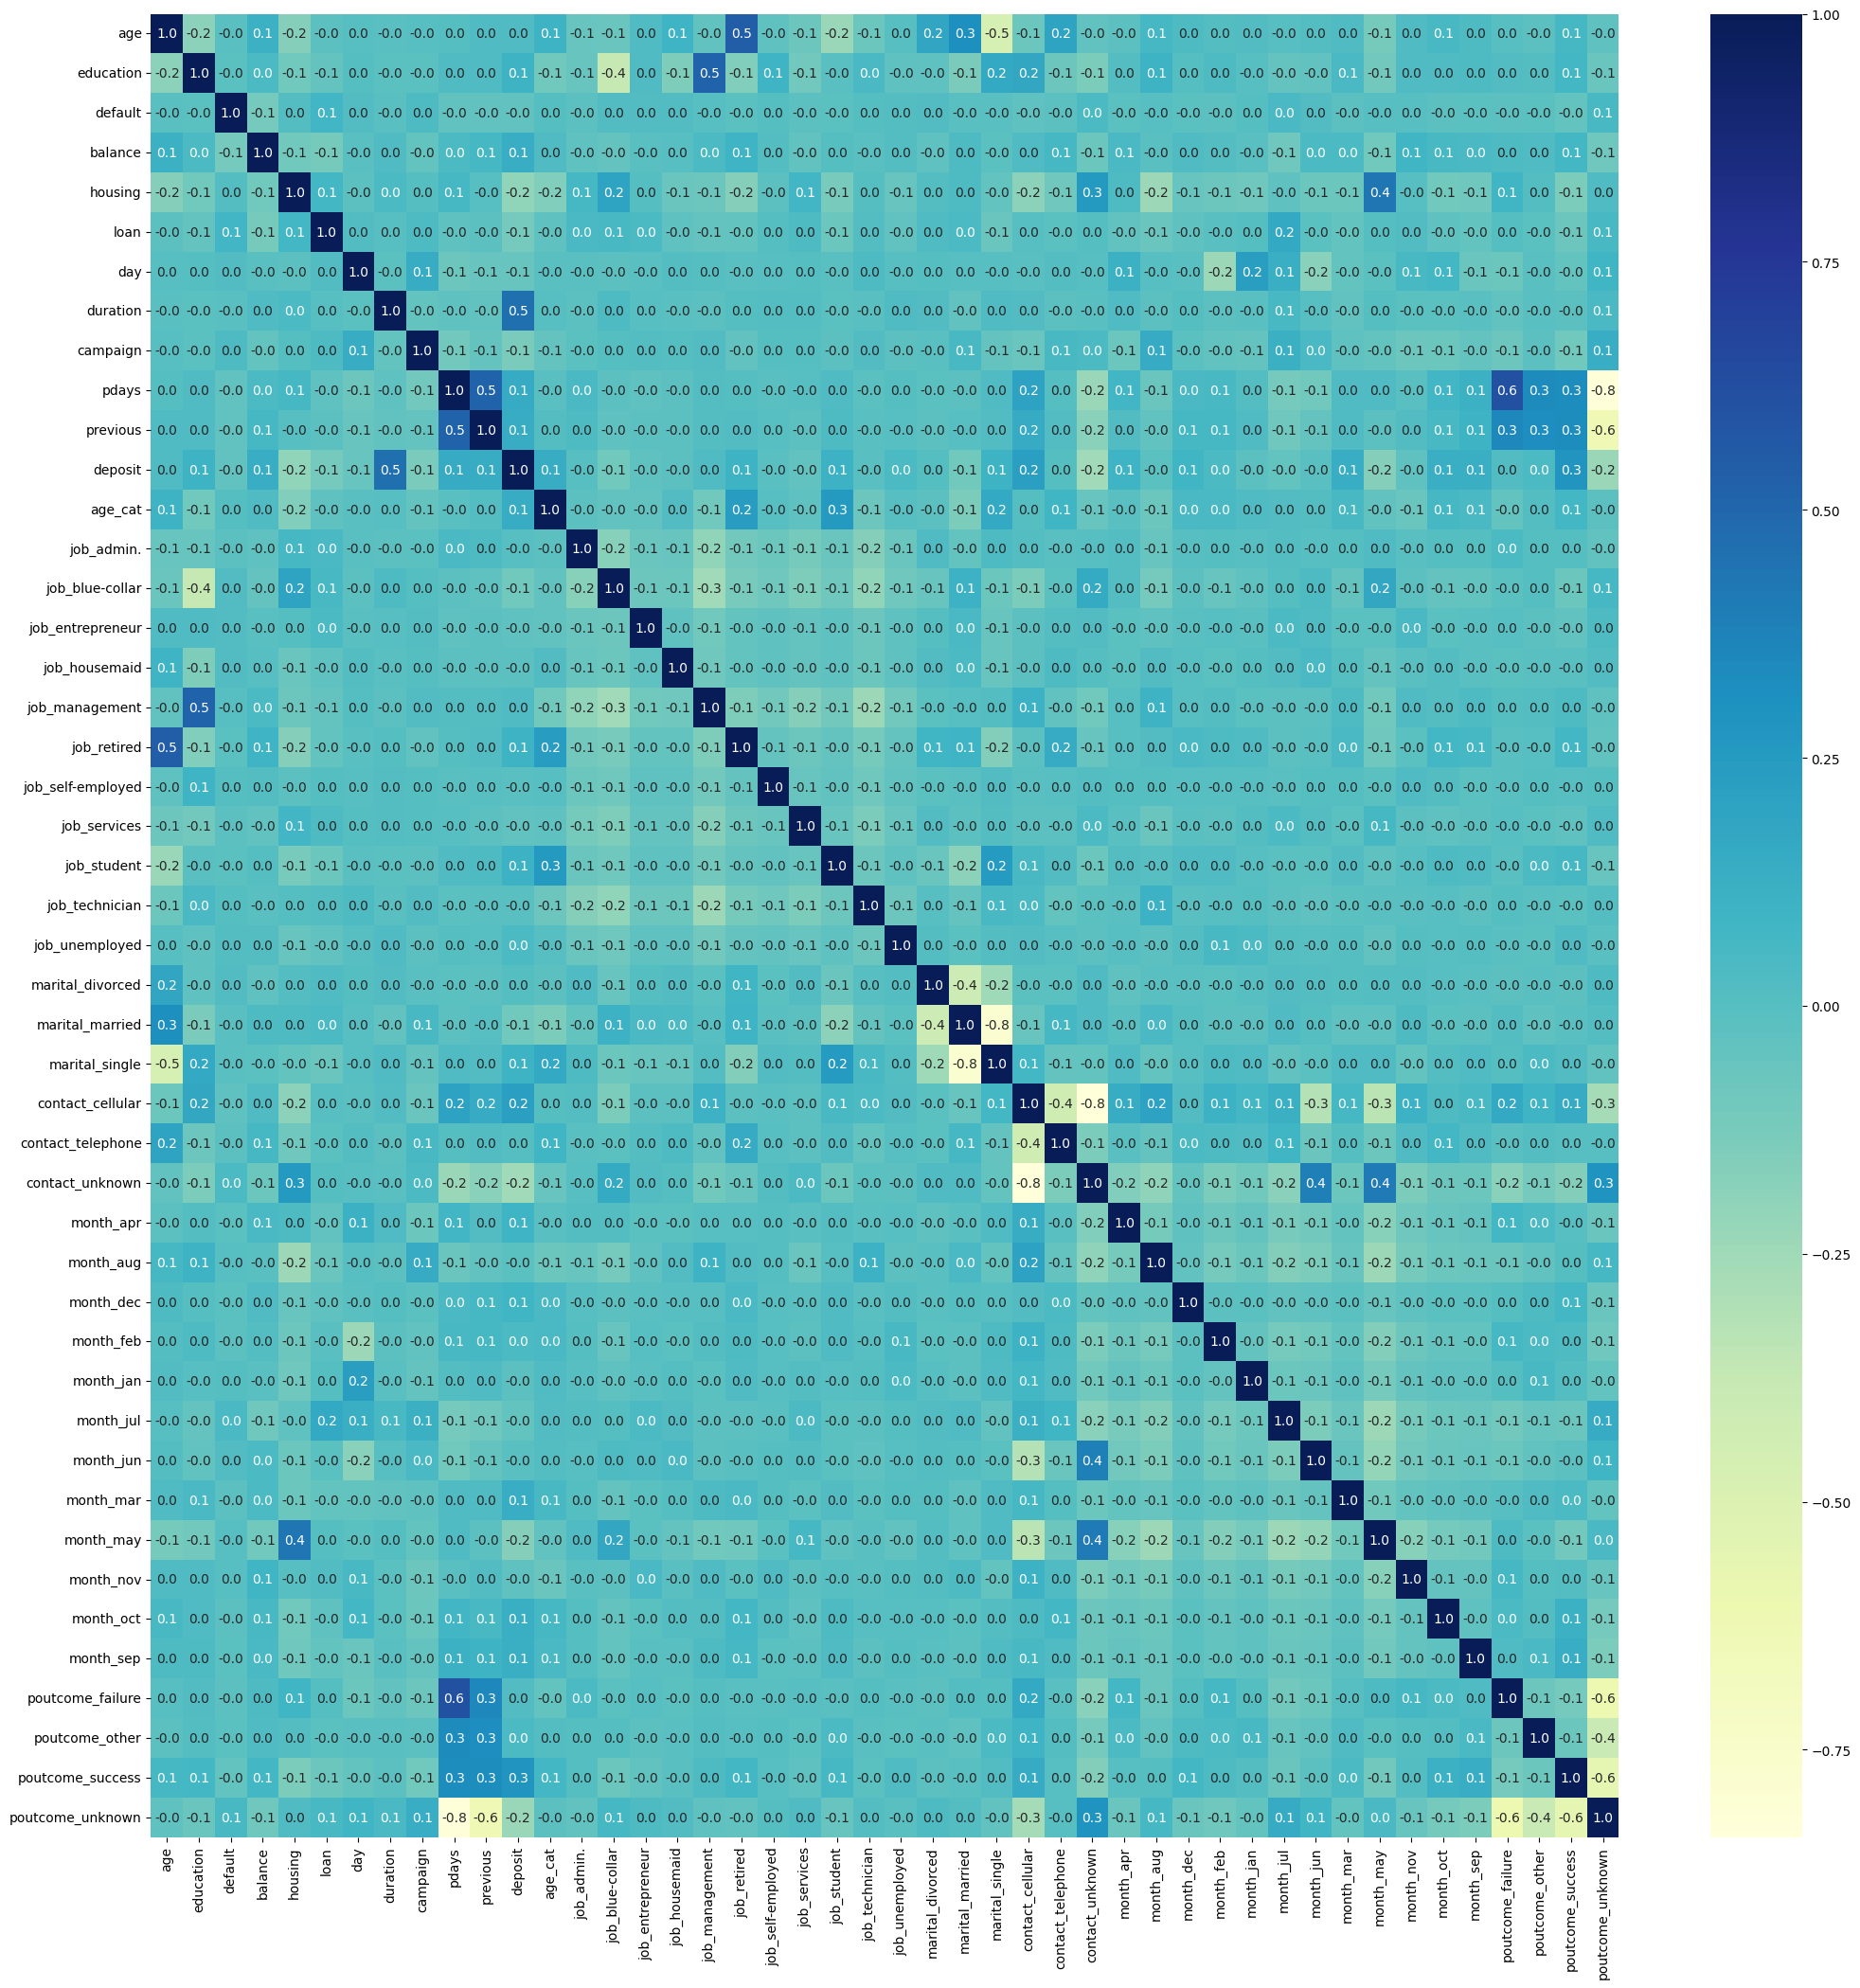

In [97]:
fig = plt.figure(figsize=(25, 25))
sns.heatmap(df.corr(), annot=True, cmap='YlGnBu',fmt=".1f")

In [98]:
df.corr()['deposit'].sort_values(ascending=False)

deposit              1.000000
duration             0.457818
poutcome_success     0.288491
contact_cellular     0.223944
pdays                0.147917
age_cat              0.141776
previous             0.141102
balance              0.135893
month_mar            0.135348
month_oct            0.130599
month_sep            0.125239
job_student          0.105563
job_retired          0.100090
education            0.098253
marital_single       0.097005
month_apr            0.092888
month_dec            0.085041
month_feb            0.044728
poutcome_other       0.039319
job_unemployed       0.039196
job_management       0.029566
age                  0.024357
poutcome_failure     0.021124
contact_telephone    0.007064
marital_divorced     0.004808
job_admin.          -0.001927
job_self-employed   -0.005194
month_jun           -0.008533
job_technician      -0.011190
month_aug           -0.018225
job_housemaid       -0.022572
month_jan           -0.025847
month_nov           -0.027754
job_entrep

### Задания 7 и 8

In [99]:
#Разобьем выборку на тестовую и обучающую
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [100]:
# рассчитайте необходимые показатели
print(f'Размер тестовой выборки = {X_test.shape}')
print(f'среднее значение целевой переменной на тестовой выборке = {y_test.mean()}')

Размер тестовой выборки = (3335, 45)
среднее значение целевой переменной на тестовой выборке = 0.46326836581709147


### Задание 9

In [101]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_cat', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [102]:
X_train = X_train[list(selector.get_feature_names_out())]
X_test = X_test[list(selector.get_feature_names_out())]

### Задание 10

In [103]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [104]:
X_train_scaled = pd.DataFrame(data = X_train_scaled, columns=selector.get_feature_names_out())
X_test_scaled = pd.DataFrame(data = X_test_scaled, columns=selector.get_feature_names_out())
X_test_scaled['balance'].mean()

0.46823674223097866

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

Для начала реализуем самый простой алгоритм, который вам известен — логистическую регрессию. В качестве алгоритма оптимизации будем использовать 'sag', в качестве значения параметра random_state возьмём число 42 и запустим 1000 итераций.

Оцените качество модели на тестовой выборке.

In [105]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

y_train_pred = log_reg.predict(X_train_scaled)
print(metrics.classification_report(y_train, y_train_pred))

y_test_pred = log_reg.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.83      6770
   macro avg       0.83      0.82      0.82      6770
weighted avg       0.83      0.83      0.82      6770

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.74      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.81      0.81      3335



### Задания 2,3,4

Теперь давайте обучим ещё один алгоритм — решающие деревья. В качестве параметров для начала возьмём следующие:

criterion = 'entropy';
random_state = 42.
Остальные параметры оставьте по умолчанию.

In [106]:
# обучите решающие деревья, настройте максимальную глубину
dec_tree = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
dec_tree.fit(X_train_scaled, y_train)

y_train_pred = dec_tree.predict(X_train_scaled)
print(metrics.classification_report(y_train, y_train_pred))

y_test_pred = dec_tree.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1790
           1       0.73      0.73      0.73      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335



Переберите различные максимальные глубины деревьев и найдите глубину дерева, для которой будет максимальное значение метрики accuracy, но при этом ещё не будет наблюдаться переобучения (т. е. не будет расти качество на обучающей выборке при неизменном качестве на тестовой).

In [107]:
acc_list = []
for i in list(range(2,20)):
    dec_tree = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=i)
    dec_tree.fit(X_train_scaled, y_train)

    y_train_pred = dec_tree.predict(X_train_scaled)
    y_test_pred = dec_tree.predict(X_test_scaled)
    
    acc_list.append([i,metrics.accuracy_score(y_train, y_train_pred), metrics.accuracy_score(y_test, y_test_pred)])

In [108]:
line_data = pd.DataFrame(np.array(acc_list), columns=['max_depth', 'acc_train', 'acc_test'])
#сделаем график в plotly, чтобы интерактивно проверить место где точность на тесте падать начинает
import plotly
import plotly.express as px

fig = px.line(
    data_frame=line_data, #DataFrame
    x='max_depth', #ось абсцисс
    y=['acc_train', 'acc_test'], #ось ординат
    height=500, #высота
    width=1000, #ширина
    title='Метрика accuracy в зависимости от глубины дерева на тренировочной и тестовой выборках' #заголовок
)
fig.show()

### Задание 5

Реализуйте оптимизацию гиперпараметров с помощью GridSearch, перебрав следующие параметры:

* 'min_samples_split': [2, 5, 7, 10];
* 'max_depth':[3,5,7].

In [121]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV
param_grid = {'min_samples_split': [2, 5, 7, 10] ,
              'max_depth':[3,5,7]
              }
grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(criterion='entropy', random_state=42),
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  

grid_search.fit(X_train_scaled, y_train) 
y_test_pred = grid_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 10}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [110]:
# обучите на ваших данных случайный лес

### Задания 2 и 3

In [111]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание 4

In [112]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 5

In [113]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [114]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna